# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [137]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [138]:
# First, lets load the dataset
data_train = dset.SVHN(
    '../data/',
    split='train',
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.43,0.44,0.47], std=[0.20,0.20,0.20])
    ])
)
data_test = dset.SVHN(
    '../data/',
    split='test',
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.43,0.44,0.47], std=[0.20,0.20,0.20])
    ])
)

In [139]:
type(data_test)

torchvision.datasets.svhn.SVHN

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [140]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [141]:
len(train_indices), len(val_indices)

(58606, 14651)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [142]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [48]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

In [49]:
prediction = torch.tensor([[0.1, 0.2, 0.3, 0.4], [0.01, 0.5, 0.3, 0.49]])
value, indices = torch.max(prediction, 1)
indices

tensor([3, 1])

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [143]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler):
    val_loss_history = [] 
    train_loss_history = []
    train_history = []
    val_history = []

    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value
        
        scheduler.step()

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_loss, val_accuracy = compute_accuracy(model, val_loader)
        
        train_loss_history.append(float(ave_loss))
        val_loss_history.append(float(val_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print(f"Average loss: {ave_loss}, Val loss: {val_loss}, Train accuracy: {train_accuracy}, Val accuracy: {val_accuracy}")
        
    return train_loss_history, val_loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    correct_samples = total_samples = loss_value = 0
    for x, y in loader:
        prediction = model(x)
        _, indices = torch.max(prediction, 1)
        loss_value += loss(prediction, y)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]
    ave_loss = loss_value / len(loader)
    accuracy = float(correct_samples) / total_samples
    return ave_loss, accuracy

loss_history, val_loss, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [63]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
                Flattener(),
                nn.Linear(3*32*32, 100),
                nn.ReLU(),
                nn.Linear(100, 100),
                nn.ReLU(),
                nn.Linear(100, 10),
)
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, val_loss, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.184384346008301, Val loss: 2.102221965789795, Train accuracy: 0.1896563491792649, Val accuracy: 0.20885946351784862
Average loss: 2.0424463748931885, Val loss: 1.9540586471557617, Train accuracy: 0.2499402791523052, Val accuracy: 0.32059245102723366
Average loss: 1.8464494943618774, Val loss: 1.7552015781402588, Train accuracy: 0.3679486741971812, Val accuracy: 0.39464882943143814
Average loss: 1.7196308374404907, Val loss: 1.6884814500808716, Train accuracy: 0.4194451080094188, Val accuracy: 0.4328714763497372
Average loss: 1.6856156587600708, Val loss: 1.667123556137085, Train accuracy: 0.43164522403849437, Val accuracy: 0.44583987441130296


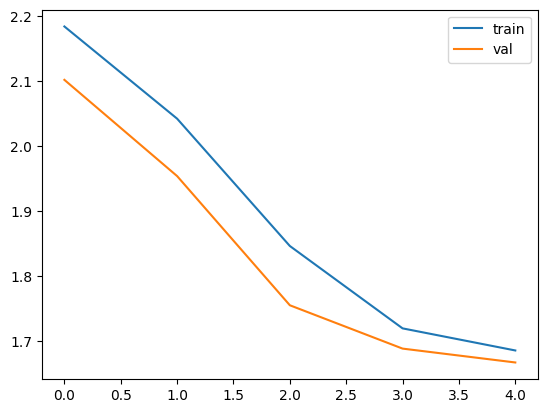

In [65]:
plt.plot(loss_history, label='train')
plt.plot(val_loss, label='val')
plt.legend()

Добавьте слой с Batch Normalization

In [68]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 10),
)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history_norm, val_loss_norm, train_history_norm, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.090519428253174, Val loss: 1.8882149457931519, Train accuracy: 0.29186431423403747, Val accuracy: 0.42174595590744657
Average loss: 1.7942949533462524, Val loss: 1.6895837783813477, Train accuracy: 0.4599529058458178, Val accuracy: 0.5302709712647601
Average loss: 1.6483207941055298, Val loss: 1.5880180597305298, Train accuracy: 0.5335460533051224, Val accuracy: 0.5720428639683298
Average loss: 1.5596363544464111, Val loss: 1.5078026056289673, Train accuracy: 0.5722963519093608, Val accuracy: 0.5965463108320251
Average loss: 1.5000531673431396, Val loss: 1.4530118703842163, Train accuracy: 0.5969525304576323, Val accuracy: 0.6253498054740291


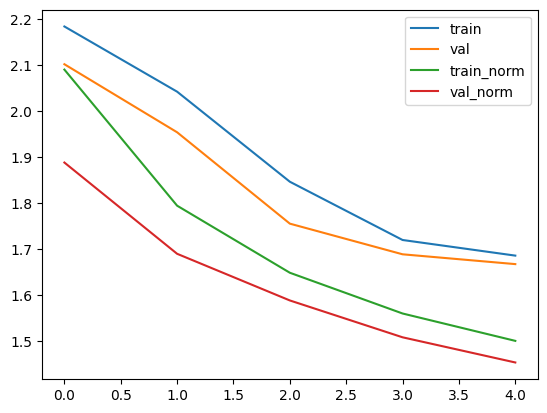

In [69]:
plt.plot(loss_history, label='train')
plt.plot(val_loss, label='val')
plt.plot(loss_history_norm, label='train_norm')
plt.plot(val_loss_norm, label='val_norm')
plt.legend()

Добавьте уменьшение скорости обучения по ходу тренировки.

In [87]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 10),
)

optimizer = optim.SGD(nn_model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)
loss_history_scheduler, val_loss_scheduler, train_history_norm, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5, scheduler)

Average loss: 1.5586246252059937, Val loss: 1.182212471961975, Train accuracy: 0.5071835648227144, Val accuracy: 0.656405706095147
Average loss: 1.0802416801452637, Val loss: 0.9748602509498596, Train accuracy: 0.6723714295464628, Val accuracy: 0.7045252883762201
Average loss: 0.889953076839447, Val loss: 0.8122445344924927, Train accuracy: 0.7310173019827322, Val accuracy: 0.7591290696880759
Average loss: 0.8316576480865479, Val loss: 0.7640458345413208, Train accuracy: 0.7459304508070846, Val accuracy: 0.7725069961094806
Average loss: 0.7482849955558777, Val loss: 0.735626757144928, Train accuracy: 0.7737774289321913, Val accuracy: 0.7828134598320934


In [88]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    initial_lr: 0.01
    lr: 0.0025
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

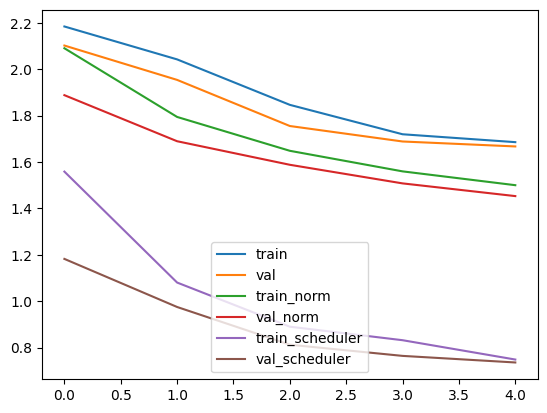

In [89]:
plt.plot(loss_history, label='train')
plt.plot(val_loss, label='val')
plt.plot(loss_history_norm, label='train_norm')
plt.plot(val_loss_norm, label='val_norm')
plt.plot(loss_history_scheduler, label='train_scheduler')
plt.plot(val_loss_scheduler, label='val_scheduler')
plt.legend()

# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [90]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode

    sampler = SubsetSampler(indices)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=sampler)

    predictions = []
    ground_truth = []

    for x, y in loader:
        prediction = model(x)
        _, indices = torch.max(prediction, 1)
        predictions.extend(indices.numpy())
        ground_truth.extend(y.numpy())
    
    return predictions, ground_truth

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

In [105]:
np.sum([predictions[i] == gt[i] for i in range(len(predictions))]) / len(predictions)

0.7828134598320934

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

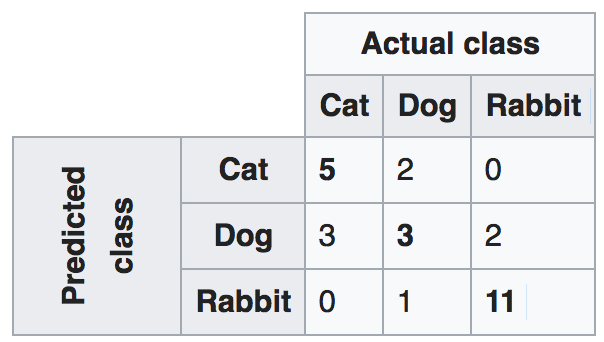

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

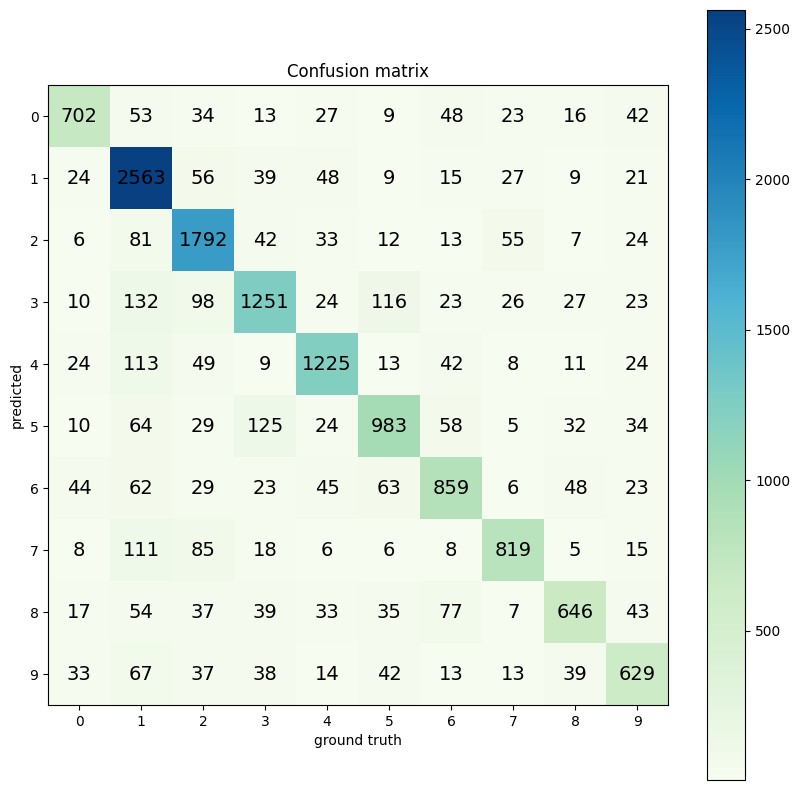

In [109]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    confusion_matrix = np.zeros((10,10), int)

    for i in range(len(predictions)):
        confusion_matrix[ground_truth[i]][predictions[i]] += 1

    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

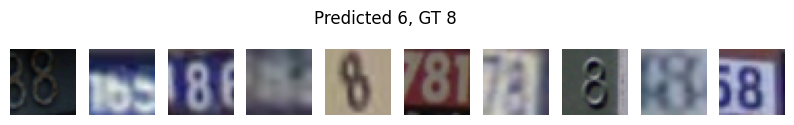

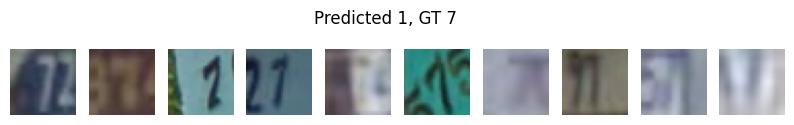

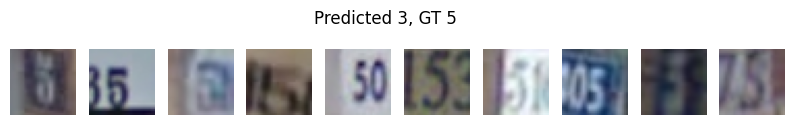

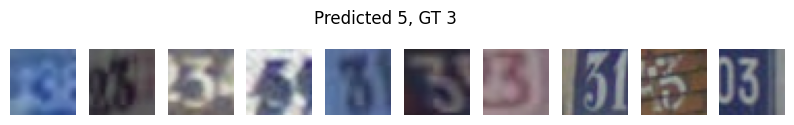

In [117]:
data_train_images = dset.SVHN('../data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1, to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    indices = np.where((np.array(predictions) == predicted_class) & (np.array(groud_truth) == gt_class))[0]
    visualize_images(val_indices[indices], data, title=f"Predicted {predicted_class}, GT {gt_class}")

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(3, 5, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(5, 3, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

In [157]:
nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 10),
)
nn_model.type(torch.FloatTensor)

loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.Adam(nn_model.parameters(), lr=1e-3) # weight_decay=1e-1
scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)
loss_history_new, val_loss_new, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 10, scheduler)

Average loss: 1.3426413536071777, Val loss: 0.9987878799438477, Train accuracy: 0.5656929324642528, Val accuracy: 0.6923076923076923
Average loss: 0.9356916546821594, Val loss: 0.7928386926651001, Train accuracy: 0.7071972153021875, Val accuracy: 0.7573544467954406
Average loss: 0.7562186121940613, Val loss: 0.7172797322273254, Train accuracy: 0.7682148585469064, Val accuracy: 0.7785816667804245
Average loss: 0.6971297860145569, Val loss: 0.6728618741035461, Train accuracy: 0.7820018428147288, Val accuracy: 0.7948262917207016
Average loss: 0.6186478137969971, Val loss: 0.630078911781311, Train accuracy: 0.8100023888339077, Val accuracy: 0.8115486997474575
Average loss: 0.6006553769111633, Val loss: 0.6060618162155151, Train accuracy: 0.8150018769409275, Val accuracy: 0.8181011535048802
Average loss: 0.5593563318252563, Val loss: 0.5911056995391846, Train accuracy: 0.827713885950244, Val accuracy: 0.8218551634700703
Average loss: 0.5466102361679077, Val loss: 0.58592689037323, Train acc

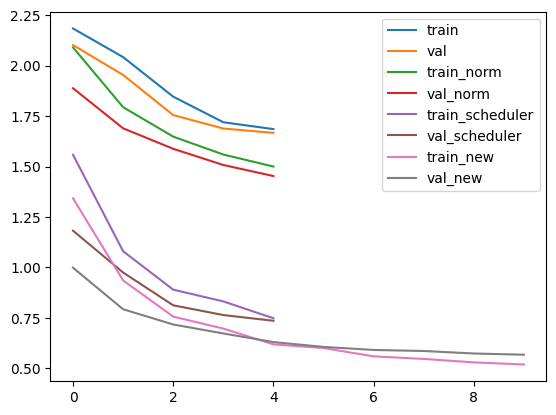

In [158]:
plt.plot(loss_history, label='train')
plt.plot(val_loss, label='val')
plt.plot(loss_history_norm, label='train_norm')
plt.plot(val_loss_norm, label='val_norm')
plt.plot(loss_history_scheduler, label='train_scheduler')
plt.plot(val_loss_scheduler, label='val_scheduler')
plt.plot(loss_history_new, label='train_new')
plt.plot(val_loss_new, label='val_new')
plt.legend()

In [159]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
loss, test_accuracy = compute_accuracy(nn_model, test_loader)
print(f"Test accuracy: {test_accuracy}")

Test accuracy: 0.8100414874001229
